
 Total number of symbols (financial instruments) is 20

Training and Evaluating for symbol 1 ...

Feature series shape: (142632, 79)

Responder series shape: (142632, 8)

Target series shape: (142632,)

Number of clean features: 43

Regression data shapes:
X shape: (142632, 51) (samples, features+responders)
y shape: (142632,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}

Best cross-validation R²: 0.6863

Model Performance:
Train MSE: 0.0985
Test MSE: 0.1007
Train R²: 0.7579
Test R²: 0.7491


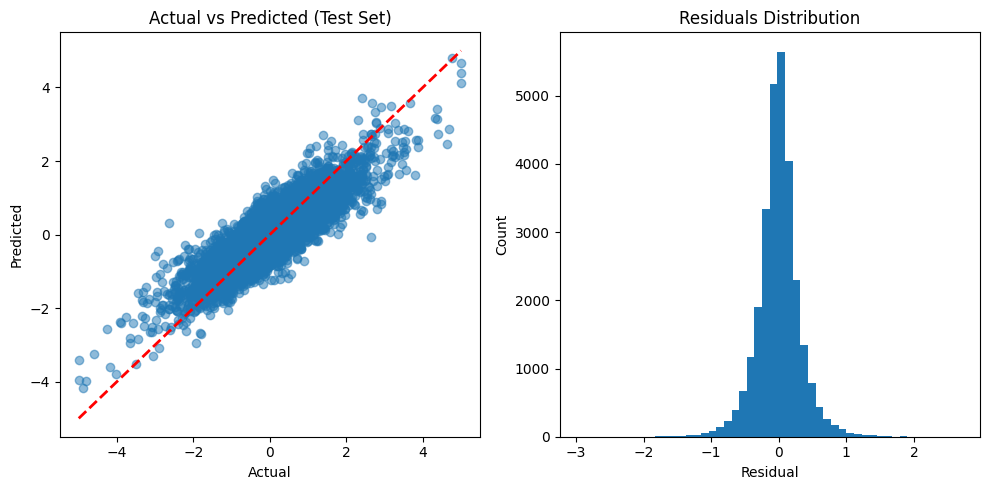


Training and Evaluating for symbol 7 ...

Feature series shape: (140085, 79)

Responder series shape: (140085, 8)

Target series shape: (140085,)

Number of clean features: 38

Regression data shapes:
X shape: (140085, 46) (samples, features+responders)
y shape: (140085,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6109

Model Performance:
Train MSE: 0.1914
Test MSE: 0.1860
Train R²: 0.7516
Test R²: 0.7512


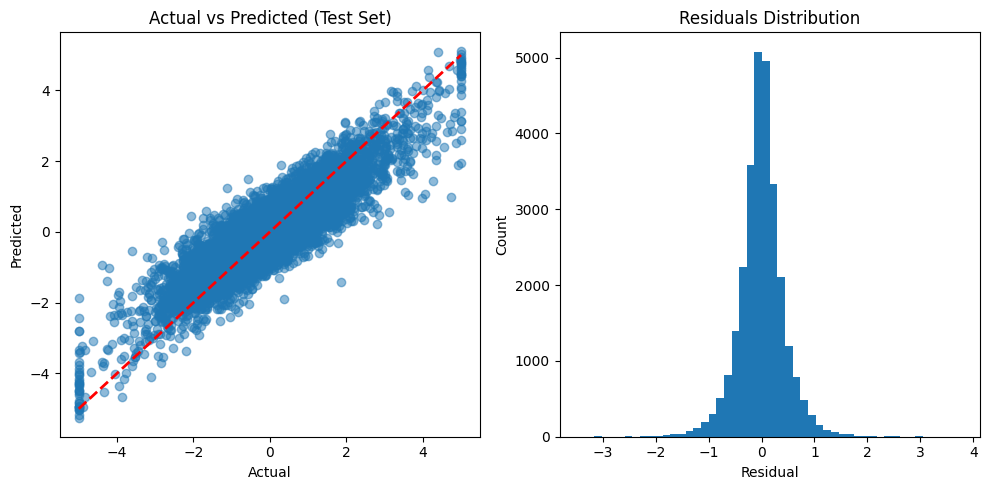


Training and Evaluating for symbol 9 ...

Feature series shape: (137538, 79)

Responder series shape: (137538, 8)

Target series shape: (137538,)

Number of clean features: 43

Regression data shapes:
X shape: (137538, 51) (samples, features+responders)
y shape: (137538,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation R²: 0.7434

Model Performance:
Train MSE: 0.0775
Test MSE: 0.0763
Train R²: 0.8515
Test R²: 0.8486


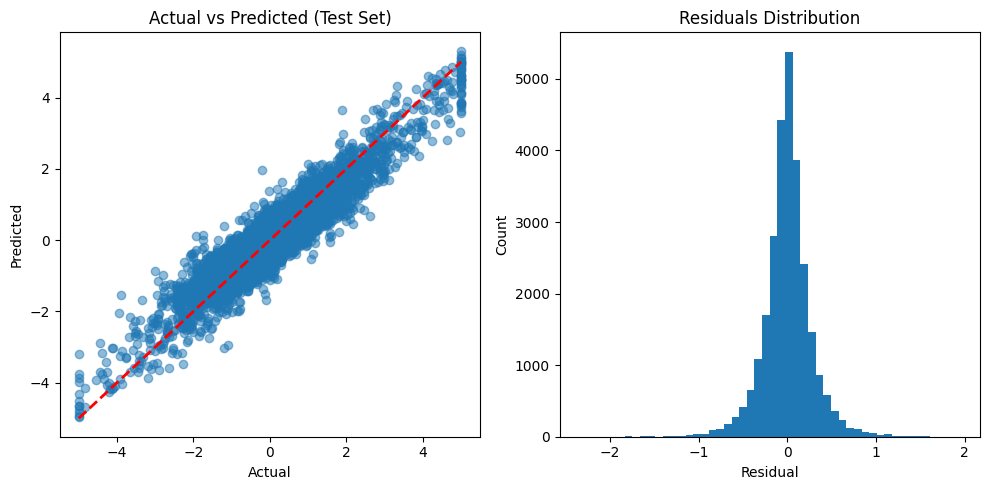


Training and Evaluating for symbol 10 ...

Feature series shape: (101880, 79)

Responder series shape: (101880, 8)

Target series shape: (101880,)

Number of clean features: 38

Regression data shapes:
X shape: (101880, 46) (samples, features+responders)
y shape: (101880,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

Best cross-validation R²: 0.6625

Model Performance:
Train MSE: 0.1613
Test MSE: 0.1614
Train R²: 0.7550
Test R²: 0.7512


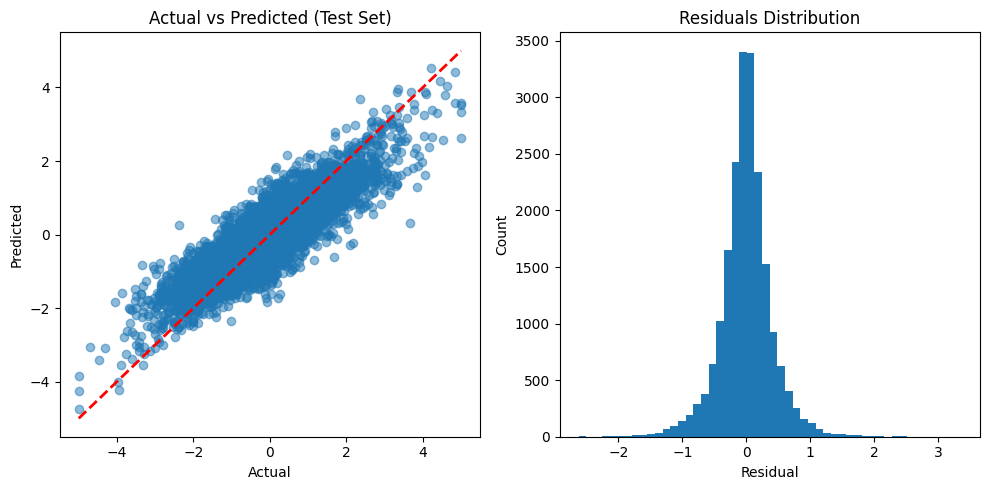


Training and Evaluating for symbol 14 ...

Feature series shape: (53487, 79)

Responder series shape: (53487, 8)

Target series shape: (53487,)

Number of clean features: 43

Regression data shapes:
X shape: (53487, 51) (samples, features+responders)
y shape: (53487,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

Best cross-validation R²: 0.7113

Model Performance:
Train MSE: 0.1444
Test MSE: 0.1428
Train R²: 0.8442
Test R²: 0.8466


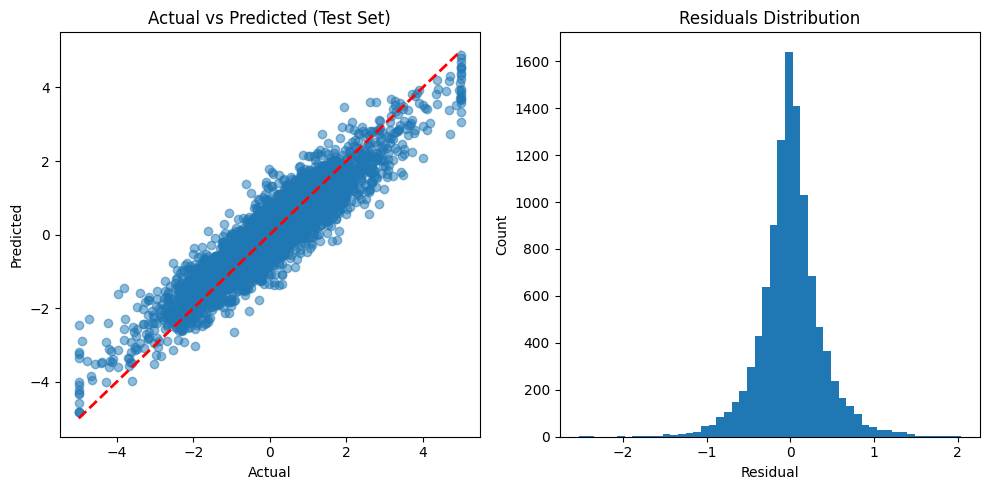


Training and Evaluating for symbol 16 ...

Feature series shape: (140934, 79)

Responder series shape: (140934, 8)

Target series shape: (140934,)

Number of clean features: 43

Regression data shapes:
X shape: (140934, 51) (samples, features+responders)
y shape: (140934,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6568

Model Performance:
Train MSE: 0.1331
Test MSE: 0.1317
Train R²: 0.7813
Test R²: 0.7771


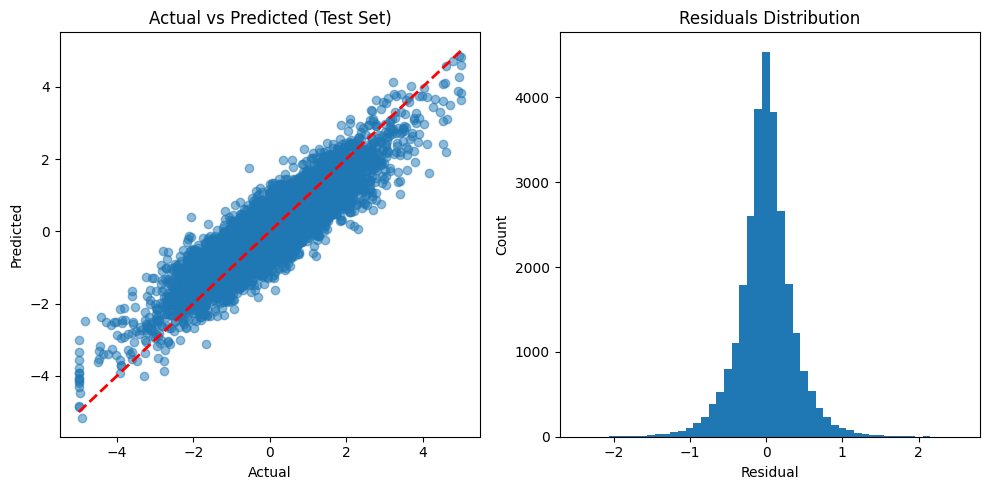


Training and Evaluating for symbol 19 ...

Feature series shape: (138387, 79)

Responder series shape: (138387, 8)

Target series shape: (138387,)

Number of clean features: 43

Regression data shapes:
X shape: (138387, 51) (samples, features+responders)
y shape: (138387,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6995

Model Performance:
Train MSE: 0.1262
Test MSE: 0.1253
Train R²: 0.8410
Test R²: 0.8448


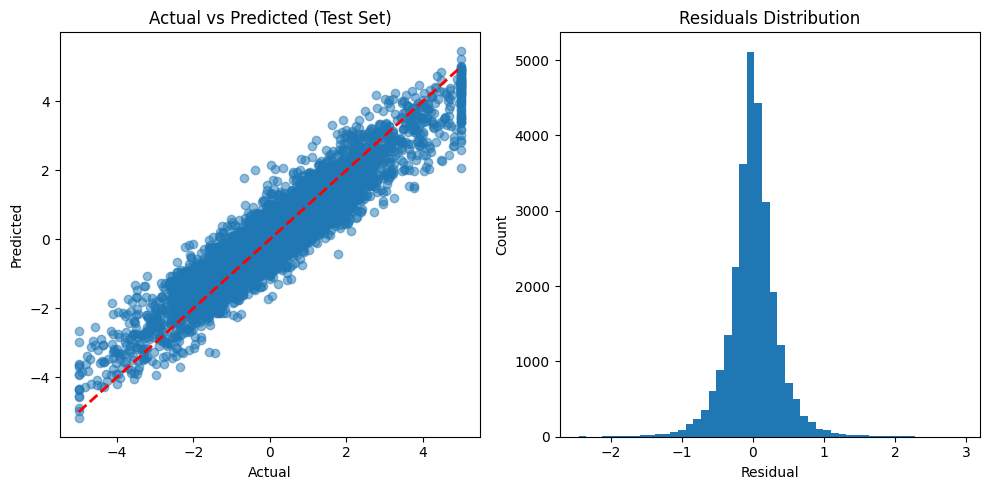


Training and Evaluating for symbol 33 ...

Feature series shape: (114615, 79)

Responder series shape: (114615, 8)

Target series shape: (114615,)

Number of clean features: 43

Regression data shapes:
X shape: (114615, 51) (samples, features+responders)
y shape: (114615,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6326

Model Performance:
Train MSE: 0.1380
Test MSE: 0.1371
Train R²: 0.7832
Test R²: 0.7858


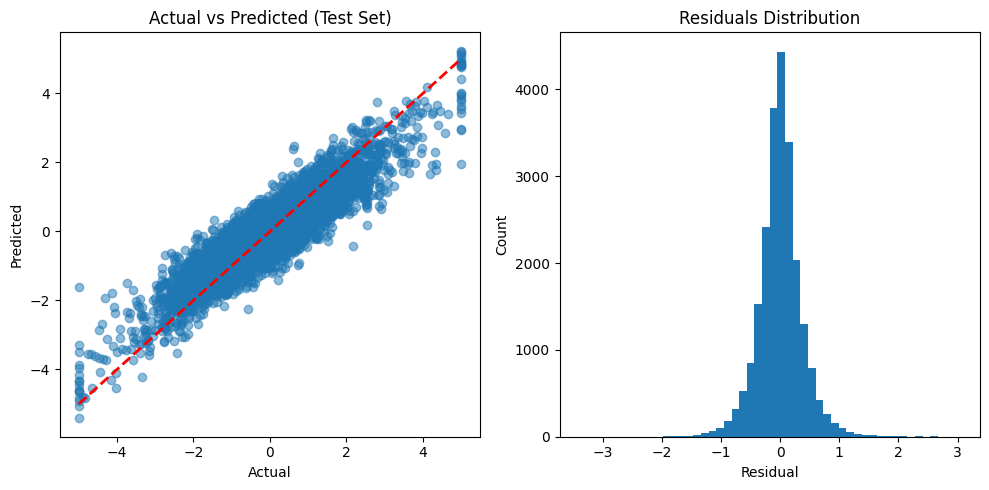


Training and Evaluating for symbol 0 ...

Feature series shape: (137538, 79)

Responder series shape: (137538, 8)

Target series shape: (137538,)

Number of clean features: 41

Regression data shapes:
X shape: (137538, 49) (samples, features+responders)
y shape: (137538,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6381

Model Performance:
Train MSE: 0.1055
Test MSE: 0.1075
Train R²: 0.7644
Test R²: 0.7631


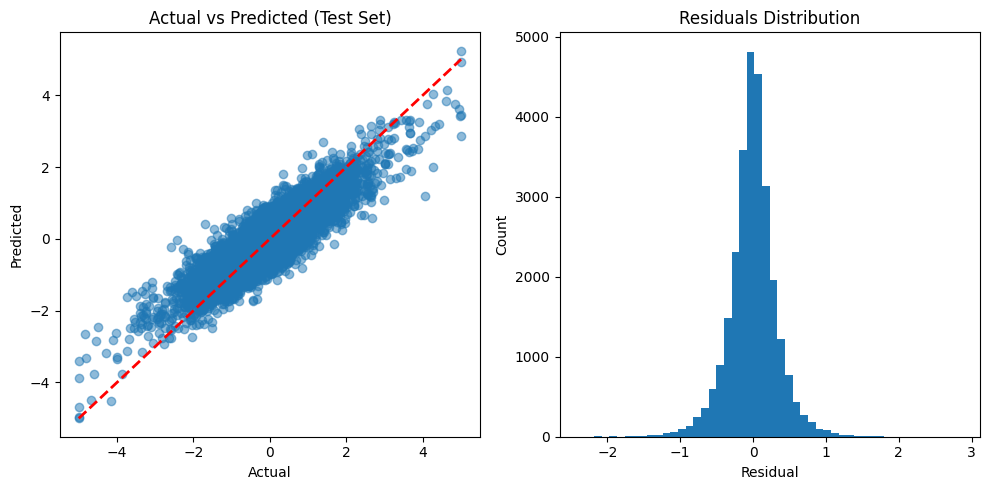


Training and Evaluating for symbol 2 ...

Feature series shape: (73014, 79)

Responder series shape: (73014, 8)

Target series shape: (73014,)

Number of clean features: 41

Regression data shapes:
X shape: (73014, 49) (samples, features+responders)
y shape: (73014,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

Best cross-validation R²: 0.6496

Model Performance:
Train MSE: 0.1478
Test MSE: 0.1563
Train R²: 0.8034
Test R²: 0.8013


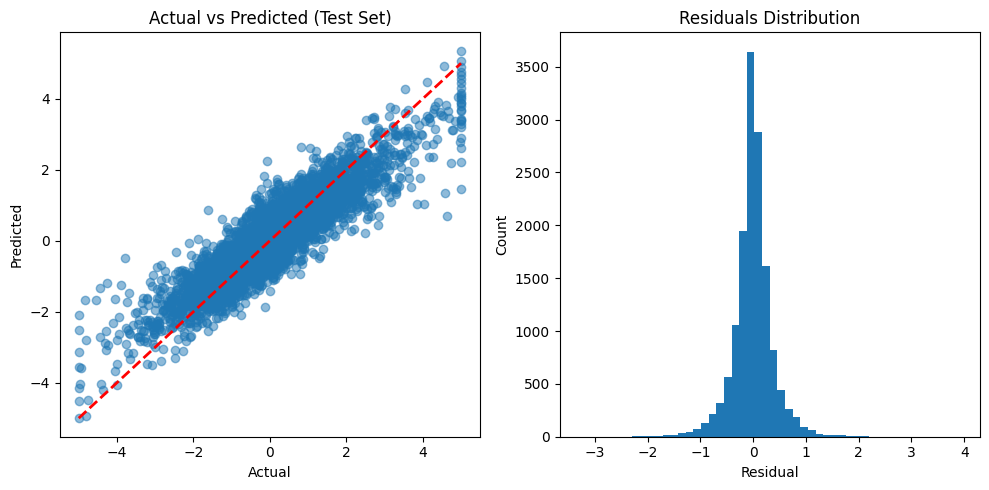


Training and Evaluating for symbol 13 ...

Feature series shape: (109521, 79)

Responder series shape: (109521, 8)

Target series shape: (109521,)

Number of clean features: 42

Regression data shapes:
X shape: (109521, 50) (samples, features+responders)
y shape: (109521,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Best cross-validation R²: 0.5881

Model Performance:
Train MSE: 0.2445
Test MSE: 0.2478
Train R²: 0.7729
Test R²: 0.7754


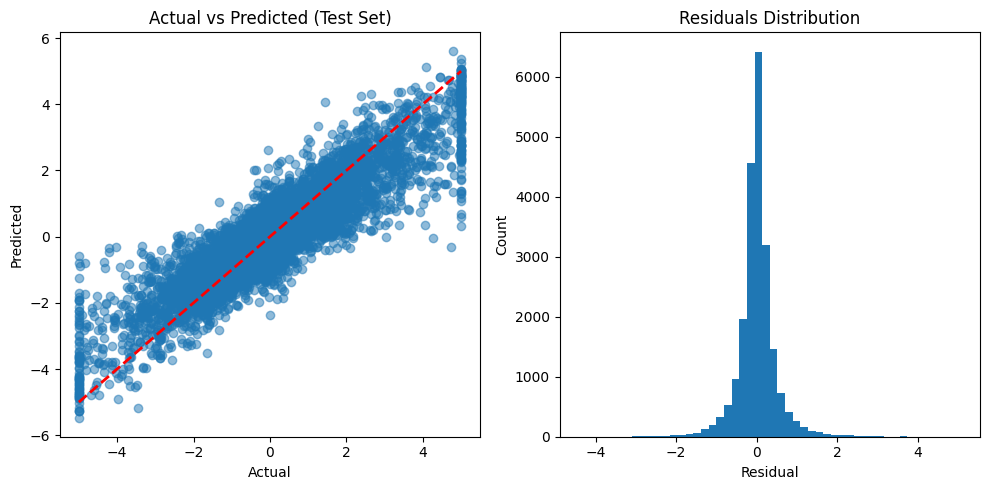


Training and Evaluating for symbol 15 ...

Feature series shape: (21225, 79)

Responder series shape: (21225, 8)

Target series shape: (21225,)

Number of clean features: 38

Regression data shapes:
X shape: (21225, 46) (samples, features+responders)
y shape: (21225,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6641

Model Performance:
Train MSE: 0.2374
Test MSE: 0.2313
Train R²: 0.8314
Test R²: 0.8406


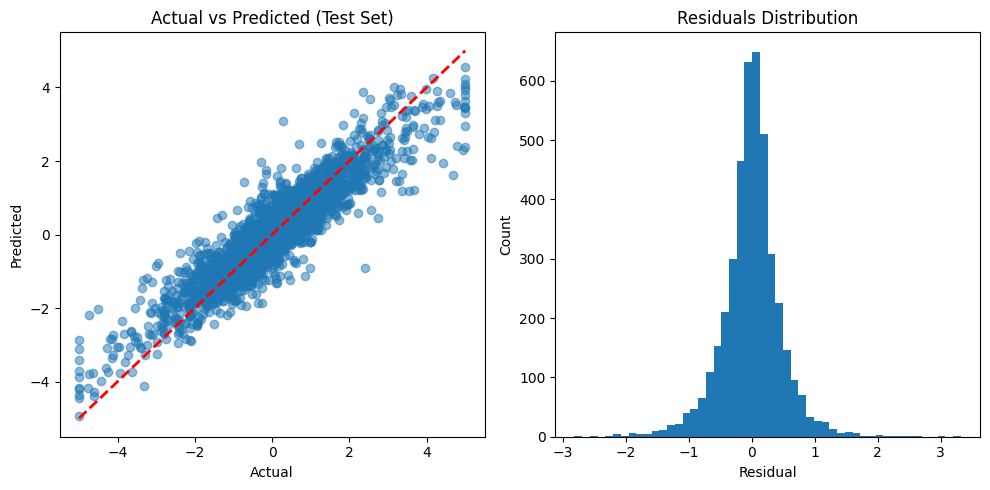


Training and Evaluating for symbol 38 ...

Feature series shape: (132444, 79)

Responder series shape: (132444, 8)

Target series shape: (132444,)

Number of clean features: 43

Regression data shapes:
X shape: (132444, 51) (samples, features+responders)
y shape: (132444,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6956

Model Performance:
Train MSE: 0.1413
Test MSE: 0.1430
Train R²: 0.8185
Test R²: 0.8175


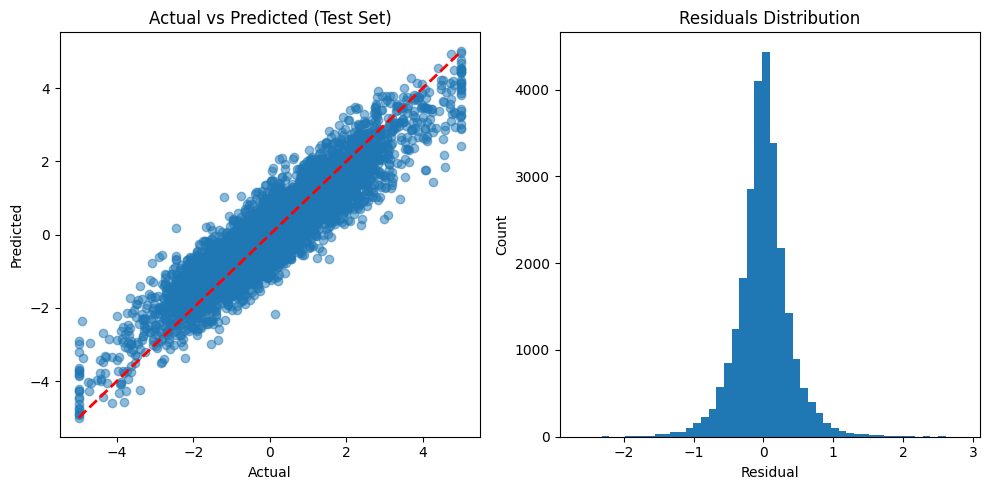


Training and Evaluating for symbol 3 ...

Feature series shape: (59430, 79)

Responder series shape: (59430, 8)

Target series shape: (59430,)

Number of clean features: 44

Regression data shapes:
X shape: (59430, 52) (samples, features+responders)
y shape: (59430,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.6723

Model Performance:
Train MSE: 0.2360
Test MSE: 0.2460
Train R²: 0.8004
Test R²: 0.7915


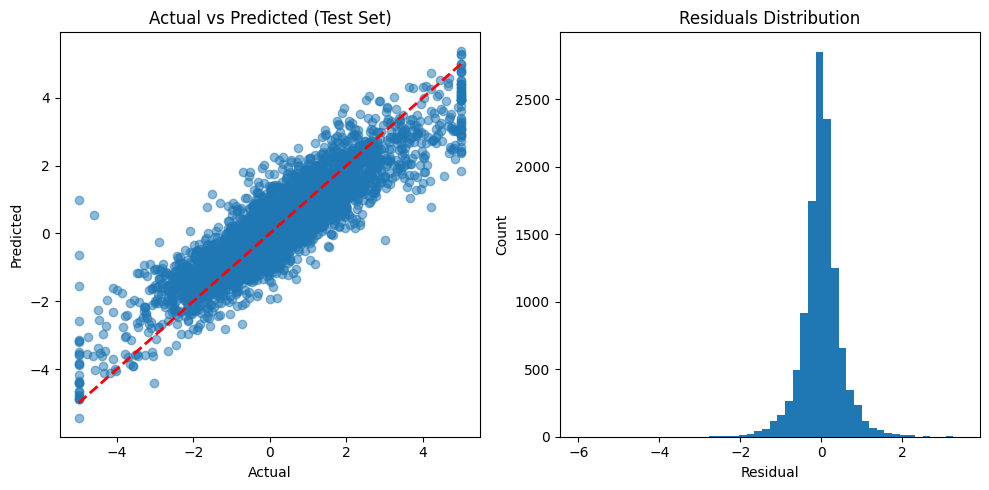


Training and Evaluating for symbol 12 ...

Feature series shape: (111219, 79)

Responder series shape: (111219, 8)

Target series shape: (111219,)

Number of clean features: 42

Regression data shapes:
X shape: (111219, 50) (samples, features+responders)
y shape: (111219,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation R²: 0.5888

Model Performance:
Train MSE: 0.1832
Test MSE: 0.1853
Train R²: 0.7894
Test R²: 0.7923


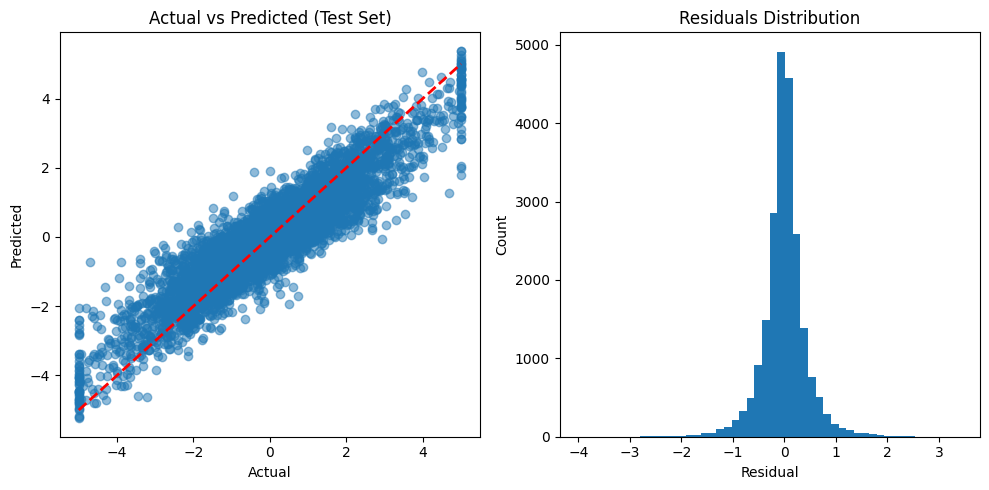


Training and Evaluating for symbol 8 ...

Feature series shape: (107823, 79)

Responder series shape: (107823, 8)

Target series shape: (107823,)

Number of clean features: 43

Regression data shapes:
X shape: (107823, 51) (samples, features+responders)
y shape: (107823,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation R²: 0.6430

Model Performance:
Train MSE: 0.1547
Test MSE: 0.1600
Train R²: 0.8079
Test R²: 0.8056


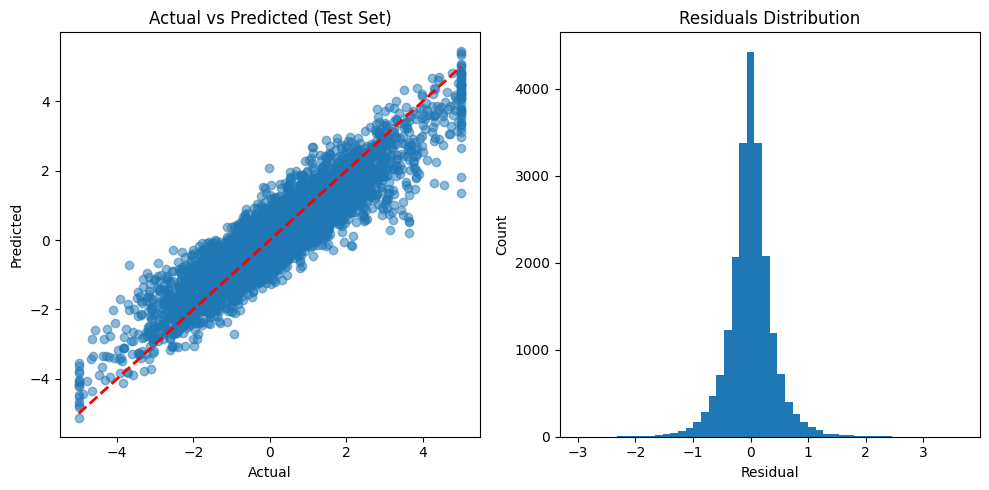


Training and Evaluating for symbol 17 ...

Feature series shape: (67920, 79)

Responder series shape: (67920, 8)

Target series shape: (67920,)

Number of clean features: 43

Regression data shapes:
X shape: (67920, 51) (samples, features+responders)
y shape: (67920,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best cross-validation R²: 0.7289

Model Performance:
Train MSE: 0.1214
Test MSE: 0.1224
Train R²: 0.8778
Test R²: 0.8821


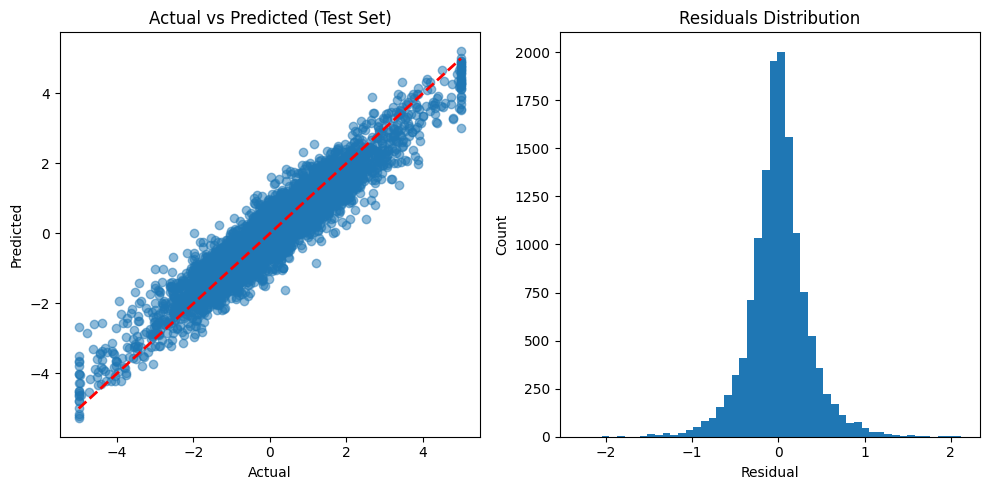


Training and Evaluating for symbol 34 ...

Feature series shape: (60279, 79)

Responder series shape: (60279, 8)

Target series shape: (60279,)

Number of clean features: 43

Regression data shapes:
X shape: (60279, 51) (samples, features+responders)
y shape: (60279,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation R²: 0.6457

Model Performance:
Train MSE: 0.1384
Test MSE: 0.1462
Train R²: 0.7727
Test R²: 0.7659


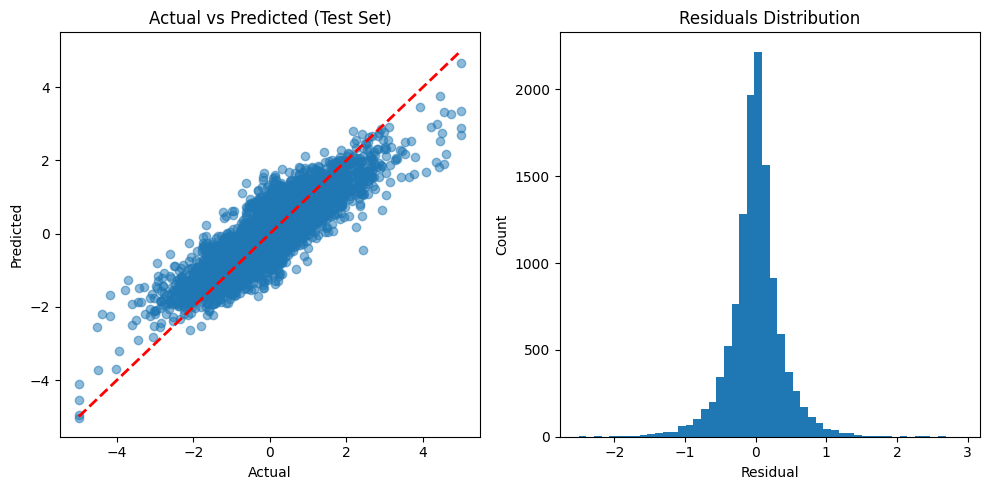


Training and Evaluating for symbol 11 ...

Feature series shape: (57732, 79)

Responder series shape: (57732, 8)

Target series shape: (57732,)

Number of clean features: 37

Regression data shapes:
X shape: (57732, 45) (samples, features+responders)
y shape: (57732,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Best cross-validation R²: 0.5613

Model Performance:
Train MSE: 0.3193
Test MSE: 0.3172
Train R²: 0.7656
Test R²: 0.7595


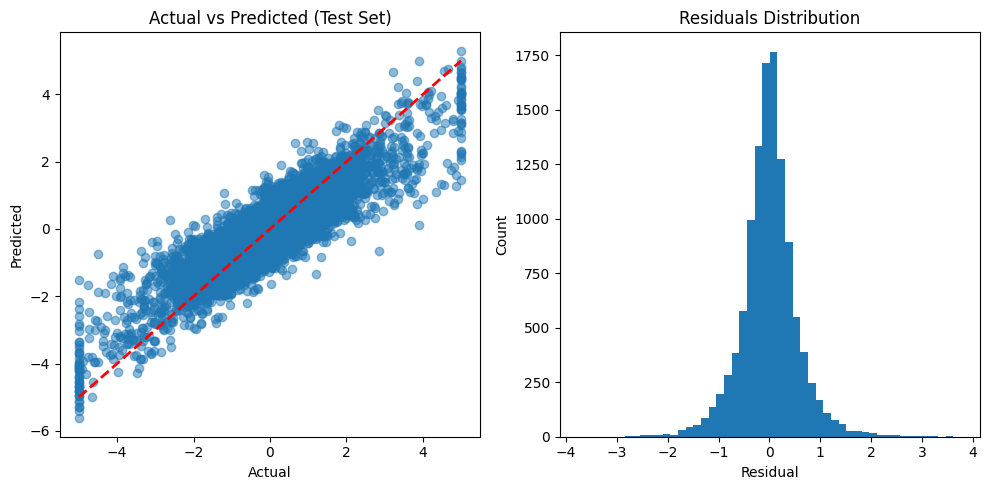


Training and Evaluating for symbol 30 ...

Feature series shape: (19527, 79)

Responder series shape: (19527, 8)

Target series shape: (19527,)

Number of clean features: 38

Regression data shapes:
X shape: (19527, 46) (samples, features+responders)
y shape: (19527,)

Total parameter combinations: 32

Total fits with 5-fold CV: 160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Best cross-validation R²: 0.5373

Model Performance:
Train MSE: 0.4549
Test MSE: 0.4472
Train R²: 0.7455
Test R²: 0.7521


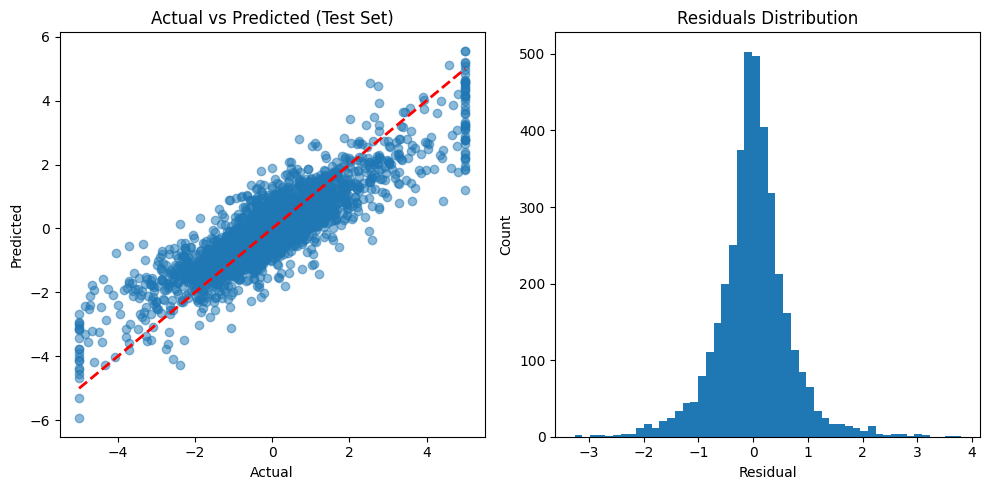

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def create_timeseries_for_symbol(df, symbol_id):
    """
    Create feature and responder time series for a given symbol
    
    Args:
        df: Input dataframe
        symbol_id: Symbol to process
    
    Returns:
        tuple: (feature_series, responder_series)
    """
    # Sort by date_id and time_id, then filter for our symbol
    df_sorted = df.sort_values(['date_id', 'time_id'])
    symbol_data = df_sorted[df_sorted['symbol_id'] == symbol_id].copy()
    
    # Get column names
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    responder_cols = [col for col in df.columns if col.startswith('responder_') and col != 'responder_6']

    target_col = 'responder_6'
    
    # Get first date and its last time for responders
    first_date = symbol_data['date_id'].min()
    first_date_last_time = symbol_data[symbol_data['date_id'] == first_date]['time_id'].max()
    first_date_last_responders = symbol_data[
        (symbol_data['date_id'] == first_date) & 
        (symbol_data['time_id'] == first_date_last_time)
    ][responder_cols]
    
    # Get all data after first date (for features)
    feature_series = symbol_data[symbol_data['date_id'] > first_date][feature_cols].copy()

    # Get all data after first date (for target)
    target_series = symbol_data[symbol_data['date_id'] > first_date][target_col].copy()

    # Get all data after first date except the last row (for responders)
    responder_data = symbol_data[symbol_data['date_id'] > first_date][responder_cols].iloc[:-1]
    
    # Add first date's last responders at the start
    responder_series = pd.concat([first_date_last_responders, responder_data])
    
    # Print verification
    print(f"\nFeature series shape: {feature_series.shape}")

    print(f"\nResponder series shape: {responder_series.shape}")

    print(f"\nTarget series shape: {target_series.shape}")

    return feature_series, responder_series, target_series

def prepare_regression_data(features, responders, target):
    """
    Prepare X and y for regression by:
    1. Removing features with NaN
    2. Combining clean features with responders
    3. Aligning with target
    """
    # Get clean features (no NaN)
    clean_features = features.loc[:, ~features.isna().any()].reset_index(drop=True)
    responders = responders.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    print(f"\nNumber of clean features: {len(clean_features.columns)}")
    
    # Make sure all have same length
    min_len = min(len(clean_features), len(responders), len(target))
    clean_features = clean_features.iloc[:min_len]
    responders = responders.iloc[:min_len]
    target = target.iloc[:min_len]
    
    # Combine clean features and responders for X
    X = pd.concat([clean_features, responders], axis=1)
    y = target
    
    print("\nRegression data shapes:")
    print(f"X shape: {X.shape} (samples, features+responders)")
    print(f"y shape: {y.shape}")
        
    return X, y

def tune_xgboost(X, y):
    """
    Tune XGBoost hyperparameters using a focused parameter grid
    """
    # Define smaller parameter grid
    param_grid = {
        'n_estimators': [100, 200],          # removed 300
        'max_depth': [4, 6],                 # just 2 values
        'learning_rate': [0.01, 0.1],        # removed middle value
        'subsample': [0.8, 1.0],             # removed 0.9
        'min_child_weight': [1, 3]           # removed 5
    }
    
    # Calculate total combinations
    total_combinations = 2 * 2 * 2 * 2 * 2  # = 32 combinations
    print(f"\nTotal parameter combinations: {total_combinations}")
    print(f"\nTotal fits with 5-fold CV: {total_combinations * 5}")
    
    # Initialize XGBoost model
    xgb = XGBRegressor(random_state=42)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit GridSearchCV
    grid_search.fit(X, y)
    
    # Print results
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation R²: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate its performance
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("\nModel Performance:")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Plot actual vs predicted for test set
    plt.figure(figsize=(10, 5))
    
    # First subplot: Actual vs Predicted scatter
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted (Test Set)')
    
    # Second subplot: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_test_pred
    plt.hist(residuals, bins=50)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.title('Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return model

if __name__ == "__main__":
    # Load and prepare data (with all features and responders)
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    list_of_symbols = df['symbol_id'].unique()

    print(f"\n Total number of symbols (financial instruments) is {len(list_of_symbols)}")
    symbol_id = list_of_symbols[0]

    for symbol_id in list_of_symbols:
        print(f"\nTraining and Evaluating for symbol {symbol_id} ...")
        features, responders, target = create_timeseries_for_symbol(df, symbol_id)
        X, y = prepare_regression_data(features, responders, target)
        
        # Tune model
        best_model = tune_xgboost(X, y)
        
        # Evaluate best model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        evaluate_model(best_model, X_train, X_test, y_train, y_test)